# NOAA Hurricane and Tornado Intensity Prediction

Predict the maximum intensity of hurricane and tornado events. Use historical hurricane and tornado records from NOAA to find patterns to predict what the maximum intensity of these storm events may be. For the project, the primary research question is, 

"Given a storm event occuring in some area within the Contiguous United States , or on a path towards the Contiguous United States, what intensity will the storm event achieve?"


The data used for this analysis will be from the [NCDC Storm Events Database](https://catalog.data.gov/dataset/ncdc-storm-events-database). This data contains a master set of all storm events since 1950. This dataset is updated frequently, but at of this time of this analysis records up to and including June 2020 will be analyzed.

To support this database, addition definition behind the different categories/f-scores of storms and surface temperatures will come from the following sources respectively.

* http://www.tornadoproject.com/cellar/fscale.htm and https://www.nhc.noaa.gov/aboutsshws.php
* https://data.giss.nasa.gov/gistemp/

<hr>

## Table of Contents

1. [Initial Data Preparation](#data-prep)
2. [Database Creation and Data Import](#database)
3. [Exploratory Data Analysis](#eda)
4. [Focused Data Preparation](#focused-data-prep)
5. [Model Training](#ml)

In [1]:
# Basic Utilities
import pandas as pd
import numpy as np
import glob
import tqdm

# Visualization 
import seaborn as sb
import matplotlib.pyplot as plt
import folium

# Database
from influxdb import DataFrameClient

# notebook properties
%matplotlib inline
pd.set_option('display.max_columns', 500)
sb.set(rc={'figure.figsize':(11,7)})

<a id='data-prep'></a>
## Initial Data Preparation
Process the raw NOAA data which is stored as a large directory of zipped CSVs. We need to decompress all of this data and get it prepared for injection into InfluxDB. InfluxDB will allow us to perform optimized time-based queries when necessary and subset the data if laptop memory is running scarce.

In [2]:
storm_data_files = glob.glob("../data/raw/StormEvents*.gz")
storm_data_files[:5]

['../data/raw\\StormEvents_details-ftp_v1.0_d1950_c20170120.csv.gz',
 '../data/raw\\StormEvents_details-ftp_v1.0_d1951_c20160223.csv.gz',
 '../data/raw\\StormEvents_details-ftp_v1.0_d1952_c20170619.csv.gz',
 '../data/raw\\StormEvents_details-ftp_v1.0_d1953_c20160223.csv.gz',
 '../data/raw\\StormEvents_details-ftp_v1.0_d1954_c20160223.csv.gz']

In [3]:
# Decompress and load all of the data
storm_data = pd.concat([pd.read_csv(x, compression='gzip') for x in storm_data_files])
storm_data.head()

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (29,34,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Capture the rogue files that weren't compressed with gzip..
non_gzip_files = glob.glob("../data/raw/StormEvents*.csv")
non_gzip_files

['../data/raw\\StormEvents_locations-ftp_v1.0_d2000_c20200707.csv']

In [5]:
non_gzip_data = pd.concat([pd.read_csv(x) for x in non_gzip_files])
storm_data = pd.concat([storm_data, non_gzip_data])
storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,NaN,10096222,OKLAHOMA,40.0,1950.0,April,Tornado,C,149.0,WASHITA,NaN,28-APR-50 14:45:00,CST,28-APR-50 14:45:00,0.0,0.0,0.0,0.0,250K,0,NaN,0.0,NaN,NaN,NaN,F3,3.4,400.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,NaN,10120412,TEXAS,48.0,1950.0,April,Tornado,C,93.0,COMANCHE,NaN,29-APR-50 15:30:00,CST,29-APR-50 15:30:00,0.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F1,11.5,200.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,NaN,10104927,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,77.0,LEHIGH,NaN,05-JUL-50 18:00:00,CST,05-JUL-50 18:00:00,2.0,0.0,0.0,0.0,25K,0,NaN,0.0,NaN,NaN,NaN,F2,12.9,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,NaN,10104928,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,43.0,DAUPHIN,NaN,05-JUL-50 18:30:00,CST,05-JUL-50 18:30:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F2,0.0,13.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,NaN,10104929,PENNSYLVANIA,42.0,1950.0,July,Tornado,C,39.0,CRAWFORD,NaN,24-JUL-50 14:40:00,CST,24-JUL-50 14:40:00,0.0,0.0,0.0,0.0,2.5K,0,NaN,0.0,NaN,NaN,NaN,F0,0.0,33.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# only select the columns needed for modeling - this dataset has an overwhelming number of columns with mostly NaNs
modeling_columns = ["BEGIN_YEARMONTH", "BEGIN_DAY", "BEGIN_TIME", "END_YEARMONTH", "END_DAY", "END_TIME", "STATE_FIPS", "YEAR",
                   "EVENT_TYPE", "BEGIN_DATE_TIME", "END_DATE_TIME", "TOR_F_SCALE", "BEGIN_LAT", "BEGIN_LON", "END_LAT", "END_LON",
                   "DATA_SOURCE","CATEGORY", "CZ_NAME"]
storm_data = storm_data[modeling_columns]
storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,40.0,1950.0,Tornado,28-APR-50 14:45:00,28-APR-50 14:45:00,F3,35.12,-99.20,35.17,-99.20,PUB,NaN,WASHITA
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,48.0,1950.0,Tornado,29-APR-50 15:30:00,29-APR-50 15:30:00,F1,31.90,-98.60,31.73,-98.60,PUB,NaN,COMANCHE
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,42.0,1950.0,Tornado,05-JUL-50 18:00:00,05-JUL-50 18:00:00,F2,40.58,-75.70,40.65,-75.47,PUB,NaN,LEHIGH
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,42.0,1950.0,Tornado,05-JUL-50 18:30:00,05-JUL-50 18:30:00,F2,40.60,-76.75,NaN,NaN,PUB,NaN,DAUPHIN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,42.0,1950.0,Tornado,24-JUL-50 14:40:00,24-JUL-50 14:40:00,F0,41.63,-79.68,NaN,NaN,PUB,NaN,CRAWFORD


### Assessing Timeseries Missingness
Downselect all of the data to only the observations that at least have a timestamp. We need a timestamp since seasonal/monthly variation will be important to our analysis. Hurricanes and tornados occuring at different stages of the season may have different maximum intensities.

**Note 10/22:** After further digging into the NOAA database, a method to impute the missing timeseries data can not be found. It seems like the missing timestamps here will remain missing within the dataset. Since we need the timestamps, let's take a look at what percentage of our dataset would be removed due to missingness.

In [7]:
n_observations = len(storm_data.index)
n_missing_begin_timestamps = sum(storm_data['BEGIN_DATE_TIME'].isna())
n_missing_end_timestamps = sum(storm_data['END_DATE_TIME'].isna())

print("{} of {} rows have a missing start timestamp - {:.2f}% missingness"\
      .format(n_missing_begin_timestamps, n_observations, 100 * n_missing_begin_timestamps / n_observations))
print("{} of {} rows have a missing end timestamp - {:.2f}% missingness"\
      .format(n_missing_end_timestamps, n_observations, 100 * n_missing_end_timestamps / n_observations))

1398963 of 3032660 rows have a missing start timestamp - 46.13% missingness
1398963 of 3032660 rows have a missing end timestamp - 46.13% missingness


Almost half of our data experiences missingness in both the `BEGIN_DATE_TIME` timestamp andthe `END_DATE_TIME` timestamp. What is good about the equal missingness here is that we are at least consistent with the number of observations with a missing timestamp (upon further inspection, we do not see records where the start timestamp is missing but the end timestamp exists and vice-versa). Let's see if the old-fashioned timestamp (string-based entry of date-time) was used more frequently. This may be a case where the newer `DateTime` datatype wasn't implemented until a certain year or until a team of developers came in and upgraded the logging of storm events.

In [8]:
# Find the missingness for the year/month column
n_missing_begin_simple_yearmo = sum(storm_data['BEGIN_YEARMONTH'].isna())
n_missing_end_simple_yearmo = sum(storm_data['END_YEARMONTH'].isna())

# Missingnes for the day column
n_missing_begin_simple_day = sum(storm_data['BEGIN_DAY'].isna())
n_missing_end_simple_day = sum(storm_data['END_DAY'].isna())

# Missingness for the time column
n_missing_begin_simple_times = sum(storm_data['BEGIN_TIME'].isna())
n_missing_end_simple_times = sum(storm_data['END_TIME'].isna())

# Let's take a look at the percentage of missingness
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_yearmo, n_observations, 100 * n_missing_begin_simple_yearmo / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_yearmo, n_observations, 100 * n_missing_end_simple_yearmo / n_observations))
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_day, n_observations, 100 * n_missing_begin_simple_day / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_day, n_observations, 100 * n_missing_end_simple_day / n_observations))
print("{} of {} rows have a missing start year-month - {:.2f}% missingness"\
      .format(n_missing_begin_simple_times, n_observations, 100 * n_missing_begin_simple_times / n_observations))
print("{} of {} rows have a missing end year-month - {:.2f}% missingness"\
      .format(n_missing_end_simple_times, n_observations, 100 * n_missing_end_simple_times / n_observations))

1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness
1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness
1398963 of 3032660 rows have a missing start year-month - 46.13% missingness
1398963 of 3032660 rows have a missing end year-month - 46.13% missingness


The results above tell us that missingness is pretty consistent across the board. Therefore, all timestamps within this dataset are telling the same story - about half of our data does not have any associated timestamp. 

**Note 10/17:** Continue researching this on the NOAA website to see if there is a way to impute the missing datetimes for these eventIDs

In [9]:
# remove the observations with the missing timestamp
available_storm_data = storm_data[~storm_data['BEGIN_YEARMONTH'].isna()].copy()
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,40.0,1950.0,Tornado,28-APR-50 14:45:00,28-APR-50 14:45:00,F3,35.12,-99.20,35.17,-99.20,PUB,NaN,WASHITA
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,48.0,1950.0,Tornado,29-APR-50 15:30:00,29-APR-50 15:30:00,F1,31.90,-98.60,31.73,-98.60,PUB,NaN,COMANCHE
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,42.0,1950.0,Tornado,05-JUL-50 18:00:00,05-JUL-50 18:00:00,F2,40.58,-75.70,40.65,-75.47,PUB,NaN,LEHIGH
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,42.0,1950.0,Tornado,05-JUL-50 18:30:00,05-JUL-50 18:30:00,F2,40.60,-76.75,NaN,NaN,PUB,NaN,DAUPHIN
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,42.0,1950.0,Tornado,24-JUL-50 14:40:00,24-JUL-50 14:40:00,F0,41.63,-79.68,NaN,NaN,PUB,NaN,CRAWFORD


### Fixing the Datetimes

The datetimes are in a slightly ambiguous format. They aren't being read in as datetime objects since the year is non-trivial to the interpreter. Let's reformat these datetime strings so we explicitly know the year (19XX or 20XX) before converting to a pandas datetime type. 

In [10]:
def prepare_year(date_string):
    """
    Given the last two digits representing the year '20 or '66, impute the beginning of the year string to
    complete the representation as '2020' or '1966'
    
    """

    year_suffix = int(date_string.split("-")[2].split(" ")[0])
    
    if year_suffix < 50:
        formatted_year = "20{}".format(year_suffix)
    else:
        formatted_year = "19{}".format(year_suffix)
        
    # reconstruct the datetime
    date_time_array = date_string.split(" ")
    date_components = date_time_array[0].split("-")
    
    # checking if the year is even correct...
    if len(formatted_year) == 4:
        reconstructed_datetime = "{}-{}-{} {}".format(date_components[0], date_components[1], formatted_year, date_time_array[1])
    else:
        reconstructed_datetime = np.NaN
    return reconstructed_datetime

In [11]:
# Fix the date-times
available_storm_data['BEGIN_DATE_TIME_REVAMP'] = pd.to_datetime(
    available_storm_data['BEGIN_DATE_TIME'].apply(prepare_year), format="%d-%b-%Y %X")
available_storm_data['END_DATE_TIME_REVAMP'] = pd.to_datetime(
    available_storm_data['END_DATE_TIME'].apply(prepare_year), format="%d-%b-%Y %X")

In [12]:
print(available_storm_data['BEGIN_DATE_TIME_REVAMP'].min())
print(available_storm_data['END_DATE_TIME_REVAMP'].max())

1950-01-03 11:00:00
2020-06-30 23:59:00


In [13]:
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
0,195004.0,28.0,1445.0,195004.0,28.0,1445.0,40.0,1950.0,Tornado,28-APR-50 14:45:00,28-APR-50 14:45:00,F3,35.12,-99.20,35.17,-99.20,PUB,NaN,WASHITA,1950-04-28 14:45:00,1950-04-28 14:45:00
1,195004.0,29.0,1530.0,195004.0,29.0,1530.0,48.0,1950.0,Tornado,29-APR-50 15:30:00,29-APR-50 15:30:00,F1,31.90,-98.60,31.73,-98.60,PUB,NaN,COMANCHE,1950-04-29 15:30:00,1950-04-29 15:30:00
2,195007.0,5.0,1800.0,195007.0,5.0,1800.0,42.0,1950.0,Tornado,05-JUL-50 18:00:00,05-JUL-50 18:00:00,F2,40.58,-75.70,40.65,-75.47,PUB,NaN,LEHIGH,1950-07-05 18:00:00,1950-07-05 18:00:00
3,195007.0,5.0,1830.0,195007.0,5.0,1830.0,42.0,1950.0,Tornado,05-JUL-50 18:30:00,05-JUL-50 18:30:00,F2,40.60,-76.75,NaN,NaN,PUB,NaN,DAUPHIN,1950-07-05 18:30:00,1950-07-05 18:30:00
4,195007.0,24.0,1440.0,195007.0,24.0,1440.0,42.0,1950.0,Tornado,24-JUL-50 14:40:00,24-JUL-50 14:40:00,F0,41.63,-79.68,NaN,NaN,PUB,NaN,CRAWFORD,1950-07-24 14:40:00,1950-07-24 14:40:00


<a id='database'></a>
## Database Creation and Data Import
With an initial inspection of the bare minimum requirement (the datetime) column performed, let's move the content of the pandas dataframe into a timeseries optimizied database (InfluxDB). While we are lucky this that current dataset fits into 16gb of RAM, that may not be the case in the future. In the future, even the analysis above may need to be performed directly on the DB instead of completely in memory with pandas with batched writing to the DB.

For the remainder of the notebook, we will query directly from the InfluxDB. This will make the timeseries queries easier and more user-friendly. 

**Influx DB Note** - Rememeber to start the database by executing influxd.exe before running this notebook. Need to modify the `conf` file to set the caching paths and open the port. Not doing this prevents any of this code from running. Luckily enough, the modification of the `conf` file is a "set it and forget it" step. Do it once, any it should never have to change it again... In theory :)

In [13]:
host='localhost'
port=8086
dbname = 'NOAA'
client = DataFrameClient(host, port, dbname)

In [14]:
print("Creating database: " + dbname)
client.create_database(dbname)

Creating database: NOAA


In [14]:
# prepare the data with a datetime index - we will use the begin-time 
available_storm_data = available_storm_data.set_index(available_storm_data['BEGIN_DATE_TIME_REVAMP'])
available_storm_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,
1950-04-28 14:45:00,195004.0,28.0,1445.0,195004.0,28.0,1445.0,40.0,1950.0,Tornado,28-APR-50 14:45:00,28-APR-50 14:45:00,F3,35.12,-99.20,35.17,-99.20,PUB,NaN,WASHITA,1950-04-28 14:45:00,1950-04-28 14:45:00
1950-04-29 15:30:00,195004.0,29.0,1530.0,195004.0,29.0,1530.0,48.0,1950.0,Tornado,29-APR-50 15:30:00,29-APR-50 15:30:00,F1,31.90,-98.60,31.73,-98.60,PUB,NaN,COMANCHE,1950-04-29 15:30:00,1950-04-29 15:30:00
1950-07-05 18:00:00,195007.0,5.0,1800.0,195007.0,5.0,1800.0,42.0,1950.0,Tornado,05-JUL-50 18:00:00,05-JUL-50 18:00:00,F2,40.58,-75.70,40.65,-75.47,PUB,NaN,LEHIGH,1950-07-05 18:00:00,1950-07-05 18:00:00
1950-07-05 18:30:00,195007.0,5.0,1830.0,195007.0,5.0,1830.0,42.0,1950.0,Tornado,05-JUL-50 18:30:00,05-JUL-50 18:30:00,F2,40.60,-76.75,NaN,NaN,PUB,NaN,DAUPHIN,1950-07-05 18:30:00,1950-07-05 18:30:00
1950-07-24 14:40:00,195007.0,24.0,1440.0,195007.0,24.0,1440.0,42.0,1950.0,Tornado,24-JUL-50 14:40:00,24-JUL-50 14:40:00,F0,41.63,-79.68,NaN,NaN,PUB,NaN,CRAWFORD,1950-07-24 14:40:00,1950-07-24 14:40:00


In [15]:
# focus on timestamps after January 1st, 1970. It seems like python influx does not play well with negative unix times
unixtime_storms = available_storm_data.loc["1970-01-01":"2025-01-01"]
unixtime_storms.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,
1970-09-04 16:50:00,197009.0,4.0,1650.0,197009.0,4.0,1650.0,5.0,1970.0,Thunderstorm Wind,04-SEP-70 16:50:00,04-SEP-70 16:50:00,NaN,35.70,-90.08,NaN,NaN,PUB,NaN,MISSISSIPPI,1970-09-04 16:50:00,1970-09-04 16:50:00
1970-10-08 16:55:00,197010.0,8.0,1655.0,197010.0,8.0,1655.0,29.0,1970.0,Tornado,08-OCT-70 16:55:00,08-OCT-70 16:55:00,F1,40.42,-92.57,40.48,-92.6,PUB,NaN,SCHUYLER,1970-10-08 16:55:00,1970-10-08 16:55:00
1970-06-04 16:15:00,197006.0,4.0,1615.0,197006.0,4.0,1615.0,28.0,1970.0,Thunderstorm Wind,04-JUN-70 16:15:00,04-JUN-70 16:15:00,NaN,33.00,-89.18,NaN,NaN,PUB,NaN,WINSTON,1970-06-04 16:15:00,1970-06-04 16:15:00
1970-06-11 22:00:00,197006.0,11.0,2200.0,197006.0,11.0,2200.0,29.0,1970.0,Thunderstorm Wind,11-JUN-70 22:00:00,11-JUN-70 22:00:00,NaN,36.78,-94.00,NaN,NaN,PUB,NaN,BARRY,1970-06-11 22:00:00,1970-06-11 22:00:00
1970-07-01 21:00:00,197007.0,1.0,2100.0,197007.0,1.0,2100.0,27.0,1970.0,Thunderstorm Wind,01-JUL-70 21:00:00,01-JUL-70 21:00:00,NaN,45.08,-94.40,NaN,NaN,PUB,NaN,MEEKER,1970-07-01 21:00:00,1970-07-01 21:00:00


In [23]:
print("Writing contents of DataFrame to DB")
prepared_data = unixtime_storms.drop(columns=["END_DATE_TIME_REVAMP", "BEGIN_DATE_TIME_REVAMP"])

client.write_points(prepared_data, measurement="storm_event", database=dbname) # Writing is very slow. use a subset for testing

Writing contents of DataFrame to DB


True

In [24]:
print("Read DataFrame")
client.query("select * from storm_event limit 5;", database=dbname)

Read DataFrame


defaultdict(list,
            {'storm_event':                               BEGIN_DATE_TIME  BEGIN_DAY  BEGIN_LAT  \
             1970-01-28 22:10:00+00:00  28-JAN-70 22:10:00       28.0      37.70   
             1970-02-01 13:15:00+00:00  01-FEB-70 13:15:00        1.0      31.78   
             1970-02-01 14:20:00+00:00  01-FEB-70 14:20:00        1.0      31.28   
             1970-02-01 14:30:00+00:00  01-FEB-70 14:30:00        1.0      31.00   
             1970-02-01 14:50:00+00:00  01-FEB-70 14:50:00        1.0      31.28   
             
                                        BEGIN_LON  BEGIN_RANGE  BEGIN_TIME  \
             1970-01-28 22:10:00+00:00     -89.00          0.0      2210.0   
             1970-02-01 13:15:00+00:00     -90.00          0.0      1315.0   
             1970-02-01 14:20:00+00:00     -90.50          0.0      1420.0   
             1970-02-01 14:30:00+00:00     -90.50          0.0      1430.0   
             1970-02-01 14:50:00+00:00     -89.78          

In [38]:
print("Group observations by a time window")
client.query("select COUNT(EVENT_TYPE) from storm_event group by time(15m)", database=dbname)

Group observations by a time window


defaultdict(list,
            {'storm_event':                            count
             1970-01-21 00:00:00+00:00      1
             1970-01-31 00:00:00+00:00      7
             1970-02-10 00:00:00+00:00      0
             1970-02-20 00:00:00+00:00      0
             1970-03-02 00:00:00+00:00      6
             ...                          ...
             2020-09-25 00:00:00+00:00      0
             2020-10-05 00:00:00+00:00      0
             2020-10-15 00:00:00+00:00      0
             2020-10-25 00:00:00+00:00      0
             2020-11-04 00:00:00+00:00      0
             
             [1856 rows x 1 columns]})

In [40]:
print("Average number of injuries per month")
client.query("select MEAN(INJURIES_DIRECT) from storm_event group by time(30d)", database=dbname)

Basic Query & Inspection


defaultdict(list,
            {'storm_event':                                mean
             1970-01-01 00:00:00+00:00  0.000000
             1970-01-31 00:00:00+00:00  0.000000
             1970-03-02 00:00:00+00:00  0.000000
             1970-04-01 00:00:00+00:00  1.043478
             1970-05-01 00:00:00+00:00  0.184615
             ...                             ...
             2020-07-07 00:00:00+00:00       NaN
             2020-08-06 00:00:00+00:00       NaN
             2020-09-05 00:00:00+00:00       NaN
             2020-10-05 00:00:00+00:00       NaN
             2020-11-04 00:00:00+00:00       NaN
             
             [620 rows x 1 columns]})

In [50]:
print("Average number of injuries per month - Replacing NaNs with 0s")
client.query("select MEAN(INJURIES_DIRECT) from storm_event group by time(30d) fill(0)", database=dbname)

Average number of injuries per month - Replacing NaNs with 0s


defaultdict(list,
            {'storm_event':                                mean
             1970-01-01 00:00:00+00:00  0.000000
             1970-01-31 00:00:00+00:00  0.000000
             1970-03-02 00:00:00+00:00  0.000000
             1970-04-01 00:00:00+00:00  1.043478
             1970-05-01 00:00:00+00:00  0.184615
             ...                             ...
             2020-07-07 00:00:00+00:00  0.000000
             2020-08-06 00:00:00+00:00  0.000000
             2020-09-05 00:00:00+00:00  0.000000
             2020-10-05 00:00:00+00:00  0.000000
             2020-11-04 00:00:00+00:00  0.000000
             
             [620 rows x 1 columns]})

In [ ]:
client.close()

<a id='eda'></a>
## Exploratory Data Analysis
Using all of the data we have (no time slicing yet), create some visualizations to explore the different features. Let's focus on the anomolies within the the different features and getting a better sense of what exists within the data, what is missing, and what we should avoid because they are informationless/uninformative feature(s).

In [16]:
unixtime_storms.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,
1970-09-04 16:50:00,197009.0,4.0,1650.0,197009.0,4.0,1650.0,5.0,1970.0,Thunderstorm Wind,04-SEP-70 16:50:00,04-SEP-70 16:50:00,NaN,35.70,-90.08,NaN,NaN,PUB,NaN,MISSISSIPPI,1970-09-04 16:50:00,1970-09-04 16:50:00
1970-10-08 16:55:00,197010.0,8.0,1655.0,197010.0,8.0,1655.0,29.0,1970.0,Tornado,08-OCT-70 16:55:00,08-OCT-70 16:55:00,F1,40.42,-92.57,40.48,-92.6,PUB,NaN,SCHUYLER,1970-10-08 16:55:00,1970-10-08 16:55:00
1970-06-04 16:15:00,197006.0,4.0,1615.0,197006.0,4.0,1615.0,28.0,1970.0,Thunderstorm Wind,04-JUN-70 16:15:00,04-JUN-70 16:15:00,NaN,33.00,-89.18,NaN,NaN,PUB,NaN,WINSTON,1970-06-04 16:15:00,1970-06-04 16:15:00
1970-06-11 22:00:00,197006.0,11.0,2200.0,197006.0,11.0,2200.0,29.0,1970.0,Thunderstorm Wind,11-JUN-70 22:00:00,11-JUN-70 22:00:00,NaN,36.78,-94.00,NaN,NaN,PUB,NaN,BARRY,1970-06-11 22:00:00,1970-06-11 22:00:00
1970-07-01 21:00:00,197007.0,1.0,2100.0,197007.0,1.0,2100.0,27.0,1970.0,Thunderstorm Wind,01-JUL-70 21:00:00,01-JUL-70 21:00:00,NaN,45.08,-94.40,NaN,NaN,PUB,NaN,MEEKER,1970-07-01 21:00:00,1970-07-01 21:00:00


### Event Types
Let's see what storm events are even in the dataset in case we wanted to expand this analysis to capture different types of events

In [17]:
unixtime_storms['EVENT_TYPE'].unique()

array(['Thunderstorm Wind', 'Tornado', 'Hail',
       'TORNADOES, TSTM WIND, HAIL', 'THUNDERSTORM WINDS/FLOODING',
       'HAIL/ICY ROADS', 'HAIL FLOODING',
       'THUNDERSTORM WINDS/FLASH FLOOD', 'THUNDERSTORM WINDS LIGHTNING',
       'THUNDERSTORM WIND/ TREES', 'THUNDERSTORM WIND/ TREE',
       'THUNDERSTORM WINDS FUNNEL CLOU', 'TORNADO/WATERSPOUT',
       'THUNDERSTORM WINDS/HEAVY RAIN', 'THUNDERSTORM WINDS HEAVY RAIN',
       'THUNDERSTORM WINDS/ FLOOD', 'High Wind', 'Flash Flood',
       'Winter Storm', 'Blizzard', 'Cold/Wind Chill', 'Heavy Snow',
       'Flood', 'Ice Storm', 'Dense Fog', 'Winter Weather', 'Avalanche',
       'Frost/Freeze', 'Lightning', 'Heat', 'Heavy Rain', 'Funnel Cloud',
       'Coastal Flood', 'Strong Wind', 'Wildfire', 'Waterspout',
       'High Surf', 'Dust Storm', 'Drought', 'Rip Current', 'Dust Devil',
       'Tropical Storm', 'Debris Flow', 'Hurricane (Typhoon)',
       'Freezing Fog', 'Storm Surge/Tide', 'Marine High Wind', 'Sleet',
       'Lake-Effect

In [18]:
# Let's only focus on hurricanes or tornados - we are looking for all observations
hurricanes_and_tornados = unixtime_storms[unixtime_storms['EVENT_TYPE'].isin([
    'Hurricane', 'Hurricane (Typhoon)','Marine Hurricane/Typhoon', 'Tornado', 'TORNADOES, TSTM WIND, HAIL',
'TORNADO/WATERSPOUT',])]
hurricanes_and_tornados.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,
1970-10-08 16:55:00,197010.0,8.0,1655.0,197010.0,8.0,1655.0,29.0,1970.0,Tornado,08-OCT-70 16:55:00,08-OCT-70 16:55:00,F1,40.42,-92.57,40.48,-92.60,PUB,NaN,SCHUYLER,1970-10-08 16:55:00,1970-10-08 16:55:00
1970-06-14 14:45:00,197006.0,14.0,1445.0,197006.0,14.0,1445.0,20.0,1970.0,Tornado,14-JUN-70 14:45:00,14-JUN-70 14:45:00,F3,39.57,-100.45,39.68,-100.32,PUB,NaN,DECATUR,1970-06-14 14:45:00,1970-06-14 14:45:00
1970-06-21 16:40:00,197006.0,21.0,1640.0,197006.0,21.0,1640.0,48.0,1970.0,Tornado,21-JUN-70 16:40:00,21-JUN-70 16:40:00,F1,32.37,-99.00,NaN,NaN,PUB,NaN,EASTLAND,1970-06-21 16:40:00,1970-06-21 16:40:00
1970-05-28 17:45:00,197005.0,28.0,1745.0,197005.0,28.0,1745.0,40.0,1970.0,Tornado,28-MAY-70 17:45:00,28-MAY-70 17:45:00,F0,34.47,-99.75,NaN,NaN,PUB,NaN,JACKSON,1970-05-28 17:45:00,1970-05-28 17:45:00
1970-05-28 18:05:00,197005.0,28.0,1805.0,197005.0,28.0,1805.0,40.0,1970.0,Tornado,28-MAY-70 18:05:00,28-MAY-70 18:05:00,F0,34.45,-99.77,NaN,NaN,PUB,NaN,JACKSON,1970-05-28 18:05:00,1970-05-28 18:05:00


### Storm Intensities

Understand the distribution of storm events that we are working with. In the project proposal, we had defined each of the different categories/F-scores and what they mean (wind-speed ranges). Let's see what type of distribution we are working with (balanced/skewed).

In [19]:
na_filled_hurricane_tornado_categories = hurricanes_and_tornados['TOR_F_SCALE'].fillna(-1)
intensity_counts = na_filled_hurricane_tornado_categories.value_counts()
intensity_counts

F0     12493
F1     10419
EF0     7155
EF1     5117
F2      4742
-1      1617
F3      1565
EF2     1386
F4       561
EFU      386
EF3      383
EF4       97
F5        69
EF5       12
Name: TOR_F_SCALE, dtype: int64

Text(0, 0.5, 'Number of Occurrences')

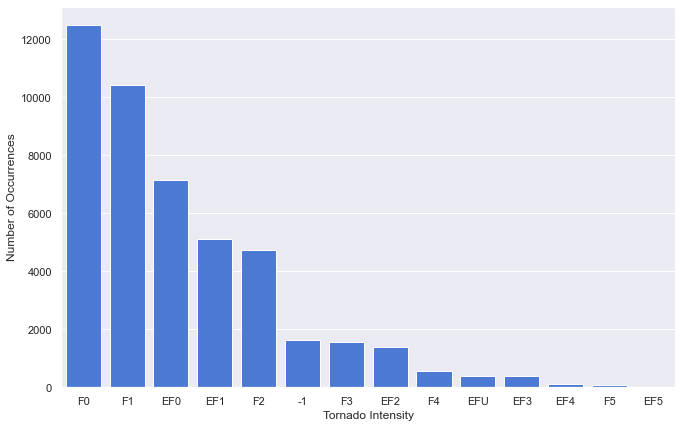

In [20]:
# Create the plot to visualize this information
ax = sb.barplot(x=intensity_counts.index, y=intensity_counts, color="#3471eb")
ax.set_xlabel("Tornado Intensity")
ax.set_ylabel("Number of Occurrences")

As expected, it looks like we have a right-skewed distribution - significantly more hurricane and tornado events that are lower strength. (This is a good thing, we don't want to see category 5 hurricanes every month...). When we move to our predictive model development, we may need to handle this class imbalance via different weighting/sampling techniques.

### Hurricane Landfall Location Inspection

Let's take a look to where these hurricanes are making landfall. Are there any anomolies within these reports? Does it seem like specific national weather zones experience more hurricanes than others?

In [21]:
# prepare the coordinates of the hurricane starting locations
hurricanes_and_tornados.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME,BEGIN_DATE_TIME_REVAMP,END_DATE_TIME_REVAMP
BEGIN_DATE_TIME_REVAMP,,,,,,,,,,,,,,,,,,,,,
1970-10-08 16:55:00,197010.0,8.0,1655.0,197010.0,8.0,1655.0,29.0,1970.0,Tornado,08-OCT-70 16:55:00,08-OCT-70 16:55:00,F1,40.42,-92.57,40.48,-92.60,PUB,NaN,SCHUYLER,1970-10-08 16:55:00,1970-10-08 16:55:00
1970-06-14 14:45:00,197006.0,14.0,1445.0,197006.0,14.0,1445.0,20.0,1970.0,Tornado,14-JUN-70 14:45:00,14-JUN-70 14:45:00,F3,39.57,-100.45,39.68,-100.32,PUB,NaN,DECATUR,1970-06-14 14:45:00,1970-06-14 14:45:00
1970-06-21 16:40:00,197006.0,21.0,1640.0,197006.0,21.0,1640.0,48.0,1970.0,Tornado,21-JUN-70 16:40:00,21-JUN-70 16:40:00,F1,32.37,-99.00,NaN,NaN,PUB,NaN,EASTLAND,1970-06-21 16:40:00,1970-06-21 16:40:00
1970-05-28 17:45:00,197005.0,28.0,1745.0,197005.0,28.0,1745.0,40.0,1970.0,Tornado,28-MAY-70 17:45:00,28-MAY-70 17:45:00,F0,34.47,-99.75,NaN,NaN,PUB,NaN,JACKSON,1970-05-28 17:45:00,1970-05-28 17:45:00
1970-05-28 18:05:00,197005.0,28.0,1805.0,197005.0,28.0,1805.0,40.0,1970.0,Tornado,28-MAY-70 18:05:00,28-MAY-70 18:05:00,F0,34.45,-99.77,NaN,NaN,PUB,NaN,JACKSON,1970-05-28 18:05:00,1970-05-28 18:05:00


In [22]:
hurricane_zones = hurricanes_and_tornados['CZ_NAME'].fillna(-1)
hurricane_zone_counts = hurricane_zones.value_counts()
hurricane_zone_counts

WASHINGTON             445
JEFFERSON              418
JACKSON                409
LINCOLN                387
POLK                   332
                      ... 
TULSA AND ROGERS         1
STORY AND BOONE          1
JAMES CITY AND YORK      1
MARIN                    1
-1                       1
Name: CZ_NAME, Length: 2011, dtype: int64

In [2]:
# Let's store a copy of this unix time data to file for logging
#unixtime_storms.to_csv("../data/interim/Hurricane-Tornados-1970-2020.csv")
unixtime_storms = pd.read_csv("../data/interim/Hurricane-Tornados-1970-2020.csv")

<a id='focused-data-prep'></a>
## Focused Data Preparation

Let's take some time to downselect to the features that we know we will be considering for prediction and join in any additional datasets that will provide environmental context. 

**Note 10/21**: Suggestion from class about introducing ocean temperatures as a strong predictor of intensity. Continue research into the sea surface temperature dataset. https://www.ncdc.noaa.gov/data-access/marineocean-data

**Note 10/21**: Look into converting the problem into a prediction of windspeed. This is a good point because we can reduce the number of redundant classes F-1 versus category-1. If time permits, move away from a classification solution to a regression solution

In [2]:
from sklearn.neighbors import KDTree
from sklearn import preprocessing

In [3]:
# now let's load in the stations so we can map the stations id to lat/lons
# Opening file 
station_tuples = list()
with open('../data/raw-temps/stations.txt', 'r')  as f:
    lines = f.readlines()
    for line in lines:
        station_id = line[:11]
        
        # handle missing data with an error code -999
        latitude = float(line[13:20]) if line[13:20] != '' else -999
        longitude = float(line[22:30]) if line[22:30] != '' else -999
        elevation_meters = float(line[32:37]) if line[32:37] != '' else -999
        
        station_tuples.append((station_id, latitude, longitude, elevation_meters))
        
stations_df = pd.DataFrame(station_tuples, columns = ["station", "latitude", "longitude", "elevation_meters"])
#stations_df.to_csv("../data/interim/NA-Stations.csv")
stations_df.head()

,station,latitude,longitude,elevation_meters
0,ACW00011604,17.1167,-61.7833,10.1
1,ACW00011647,17.1333,-61.7833,19.2
2,AE000041196,25.3330,55.5170,34.0
3,AEM00041194,25.2550,55.3640,10.4
4,AEM00041217,24.4330,54.6510,26.8


In [3]:
# Let's load in some refined information on surface temperatures\
# accords to docs, columns are <station_id>, <date>, <observation_type>, <observation-value> , additional-uniformative-columns
usa_data = None
temp_files = glob.glob("../data/raw-temps/*.csv.gz")
for current_temp_file in tqdm.tqdm(temp_files):
    data = pd.read_csv(current_temp_file, compression='gzip', header=None, usecols=[0,1,2,3])
    data.columns = ['station', 'date', 'observation_type', 'observation_value']
    
    # limit ourselves to roughly north america using the station locations with some core weather properties
    data_w_stations = pd.merge(data, stations_df, left_on='station', right_on='station')
    data_w_stations = data_w_stations[(data_w_stations['latitude'].between(10,50)) & 
                               (data_w_stations['longitude'].between(-130, -60)) &
                               (data_w_stations['observation_type'].isin(["PRCP","SNOW","SNWD","TMAX","TMIN","PSUN","TSUN","WSFG"]))]
    
    # let's pivot the data such that our different observations types are separate columns linked to each station-date
    data_w_stations = data_w_stations.pivot_table(index=["date","station"],
                                                columns=["observation_type"], values='observation_value').reset_index()
    
    # join the lat/lons back in
    usa_weather = pd.merge(data_w_stations, stations_df, left_on="station", right_on="station")
    usa_weather.to_csv("../data/interim/NA-temps/{}.csv".format(current_temp_file.split("\\")[-1].split(".")[0]))


100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [1:25:58<00:00, 101.16s/it]


In [46]:
# create a spatial data structure (KDtree) containing all station locations
stations_tree = KDTree(np.asarray(list(zip(stations_df.longitude, stations_df.latitude))))

# join the temperature data with the storm event database - perform on a per-year basis
for current_year in tqdm.trange(1970,2021):
    # storm data filter for current year
    current_year_storms = unixtime_storms[unixtime_storms['YEAR'] == current_year]
    
    # drop any rows where we don't have a coordinate
    current_year_storms = current_year_storms.dropna(subset=["BEGIN_LON", "BEGIN_LAT"])
    
    if len(current_year_storms.index) > 0:
        # query each point in storm data for nearest weather station. 
        nearest_indicies = stations_tree.query(np.asarray(list(zip(current_year_storms.BEGIN_LON, current_year_storms.BEGIN_LAT))),
                                               k=1, return_distance=False).flatten()
        applicable_stations = stations_df.iloc[nearest_indicies]

        # find the weather entry for that station on the same day
        storms_with_stations = pd.concat([current_year_storms.reset_index(), applicable_stations.reset_index()], axis=1)
        storms_with_stations['date'] = storms_with_stations['BEGIN_DATE_TIME_REVAMP'].apply(lambda dt: "{}{}{}".format(dt[0:4], dt[5:7], dt[8:10]))
        storms_with_stations['date'] = storms_with_stations['date'].astype(int)
        current_year_weather = pd.read_csv("../data/interim/NA-temps/{}.csv".format(current_year))

        # Note, for the following join, we will drop rows where we do not have a weather report on the same day. This is expected behavior
        full_storm_and_weather = pd.merge(storms_with_stations, current_year_weather,
                                          left_on=["station", "date"], right_on=["station", "date"])

        # write out the current year's combined dataset
        full_storm_and_weather.to_csv("../data/interim/storm-events-with-weather/{}.csv".format(current_year))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [03:40<00:00,  4.32s/it]


In [3]:
# combine all of the intermediate files
prepared_storm_data = pd.concat([pd.read_csv(x) for x in glob.glob("../data/interim/storm-events-with-weather/*")])

# Filter for only hurricane and tornado events
prepared_hurricanes_tornados = prepared_storm_data[prepared_storm_data['EVENT_TYPE'].isin([
    'Hurricane', 'Hurricane (Typhoon)','Marine Hurricane/Typhoon', 'Tornado', 'TORNADOES, TSTM WIND, HAIL',
'TORNADO/WATERSPOUT',])]

prepared_hurricanes_tornados.head()

,Unnamed: 0,index,BEGIN_DATE_TIME_REVAMP,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,STATE_FIPS,YEAR,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME,TOR_F_SCALE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,CATEGORY,CZ_NAME,BEGIN_DATE_TIME_REVAMP.1,END_DATE_TIME_REVAMP,index.1,station,latitude_x,longitude_x,elevation_meters_x,date,Unnamed: 0.1,PRCP,PSUN,SNOW,SNWD,TMAX,TMIN,TSUN,WSFG,latitude_y,longitude_y,elevation_meters_y
17,17,54,1970-05-28 17:45:00,197005.0,28.0,1745.0,197005.0,28.0,1745.0,40.0,1970.0,Tornado,28-MAY-70 17:45:00,28-MAY-70 17:45:00,F0,34.47,-99.75,NaN,NaN,PUB,NaN,JACKSON,1970-05-28 17:45:00,1970-05-28 17:45:00,104653,USC00342836,34.4667,-99.6500,445.0,19700528,2028297,69.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,34.4667,-99.6500,445.0
18,18,55,1970-05-28 18:05:00,197005.0,28.0,1805.0,197005.0,28.0,1805.0,40.0,1970.0,Tornado,28-MAY-70 18:05:00,28-MAY-70 18:05:00,F0,34.45,-99.77,NaN,NaN,PUB,NaN,JACKSON,1970-05-28 18:05:00,1970-05-28 18:05:00,104653,USC00342836,34.4667,-99.6500,445.0,19700528,2028297,69.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,34.4667,-99.6500,445.0
19,19,56,1970-05-28 18:30:00,197005.0,28.0,1830.0,197005.0,28.0,1830.0,40.0,1970.0,Tornado,28-MAY-70 18:30:00,28-MAY-70 18:30:00,F0,34.43,-99.70,NaN,NaN,PUB,NaN,JACKSON,1970-05-28 18:30:00,1970-05-28 18:30:00,104653,USC00342836,34.4667,-99.6500,445.0,19700528,2028297,69.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,34.4667,-99.6500,445.0
21,21,60,1970-05-29 17:50:00,197005.0,29.0,1750.0,197005.0,29.0,1750.0,40.0,1970.0,Tornado,29-MAY-70 17:50:00,29-MAY-70 17:50:00,F0,35.42,-96.37,NaN,NaN,PUB,NaN,OKFUSKEE,1970-05-29 17:50:00,1970-05-29 17:50:00,104830,USC00346638,35.4253,-96.3033,285.0,19700529,2054587,429.0,NaN,0.0,0.0,283.0,156.0,NaN,NaN,35.4253,-96.3033,285.0
31,31,113,1970-05-09 20:15:00,197005.0,9.0,2015.0,197005.0,9.0,2015.0,40.0,1970.0,Tornado,09-MAY-70 20:15:00,09-MAY-70 20:15:00,F1,36.37,-95.05,NaN,NaN,PUB,NaN,MAYES,1970-05-09 20:15:00,1970-05-09 20:15:00,104916,USC00348380,36.3894,-95.0597,208.8,19700509,2066885,0.0,NaN,0.0,0.0,256.0,200.0,NaN,NaN,36.3894,-95.0597,208.8


In [4]:
# one final time, let's downselect the columns to remove near-duplicates from our previous joins
training_data_unprepped = prepared_hurricanes_tornados[["BEGIN_TIME", "STATE_FIPS", 
                                                        "TOR_F_SCALE", "DATA_SOURCE", "CATEGORY", "CZ_NAME", 
                                                        "station", "latitude_x", "longitude_x", "elevation_meters_x",
                                                       "PRCP", "PSUN","SNOW","SNWD","TMAX","TMIN","TSUN","WSFG", "EVENT_TYPE"]].copy()
training_data_unprepped.head()

,BEGIN_TIME,STATE_FIPS,TOR_F_SCALE,DATA_SOURCE,CATEGORY,CZ_NAME,station,latitude_x,longitude_x,elevation_meters_x,PRCP,PSUN,SNOW,SNWD,TMAX,TMIN,TSUN,WSFG,EVENT_TYPE
17,1745.0,40.0,F0,PUB,NaN,JACKSON,USC00342836,34.4667,-99.6500,445.0,69.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Tornado
18,1805.0,40.0,F0,PUB,NaN,JACKSON,USC00342836,34.4667,-99.6500,445.0,69.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Tornado
19,1830.0,40.0,F0,PUB,NaN,JACKSON,USC00342836,34.4667,-99.6500,445.0,69.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Tornado
21,1750.0,40.0,F0,PUB,NaN,OKFUSKEE,USC00346638,35.4253,-96.3033,285.0,429.0,NaN,0.0,0.0,283.0,156.0,NaN,NaN,Tornado
31,2015.0,40.0,F1,PUB,NaN,MAYES,USC00348380,36.3894,-95.0597,208.8,0.0,NaN,0.0,0.0,256.0,200.0,NaN,NaN,Tornado


In [5]:
# Look at the data types to help inform which columns will need to be encoded
training_data_unprepped.dtypes

BEGIN_TIME            float64
STATE_FIPS            float64
TOR_F_SCALE            object
DATA_SOURCE            object
CATEGORY              float64
CZ_NAME                object
station                object
latitude_x            float64
longitude_x           float64
elevation_meters_x    float64
PRCP                  float64
PSUN                  float64
SNOW                  float64
SNWD                  float64
TMAX                  float64
TMIN                  float64
TSUN                  float64
WSFG                  float64
EVENT_TYPE             object
dtype: object

In [6]:
# Create dummy variables for categoricals (strings)
station_encoder = preprocessing.LabelEncoder() # STATION_NAME
station_encoder.fit(training_data_unprepped['station'])
training_data_unprepped['station_enc'] = station_encoder.transform(training_data_unprepped['station'])

cz_encoder = preprocessing.LabelEncoder() # CZ_NAME
cz_encoder.fit(training_data_unprepped['CZ_NAME'].astype(str))
training_data_unprepped['CZ_NAME_enc'] = cz_encoder.transform(training_data_unprepped['CZ_NAME'].astype(str))

event_encoder = preprocessing.LabelEncoder() # EVENT_TYPE
event_encoder.fit(training_data_unprepped['EVENT_TYPE'])
training_data_unprepped['EVENT_TYPE_enc'] = event_encoder.transform(training_data_unprepped['EVENT_TYPE'])

data_source_encoder = preprocessing.LabelEncoder() # DATA_SOURCE
data_source_encoder.fit(training_data_unprepped['DATA_SOURCE'])
training_data_unprepped['DATA_SOURCE_enc'] = data_source_encoder.transform(training_data_unprepped['DATA_SOURCE'])

# encode our target vectors, ensure Tor scale and category don't overlap ( category 1 NOT EQUAL to F1)
training_data_unprepped['Target'] = training_data_unprepped.apply(lambda row: row['TOR_F_SCALE'] if not pd.isnull(row['TOR_F_SCALE']) else 
                              ("NO_TARGET" if pd.isnull(row['CATEGORY']) else row['CATEGORY']), axis=1)

# Drop any remaining rows without a category or F-score
training_data_prepped = training_data_unprepped[training_data_unprepped['Target'] != "NO_TARGET"].copy()

target_encoder = preprocessing.LabelEncoder() # DATA_SOURCE
target_encoder.fit(training_data_prepped['Target'])
training_data_prepped['Target_enc'] = target_encoder.transform(training_data_prepped['Target'])

# remove the old categoricals in favor of the encoded variables and save for logging
training_data = training_data_prepped[["BEGIN_TIME", "STATE_FIPS", "latitude_x", "longitude_x", "elevation_meters_x",
                                      "PRCP","PSUN","SNOW","SNWD","TMAX","TMIN","TSUN","WSFG",
                                      "station_enc","CZ_NAME_enc","EVENT_TYPE_enc","DATA_SOURCE_enc","Target_enc"]]

# replace any existsing Nan values with -1 error code
training_data = training_data.fillna(-1)
training_data.to_csv("../data/processed/storms_events_training.csv", index=False)
training_data.head()

,BEGIN_TIME,STATE_FIPS,latitude_x,longitude_x,elevation_meters_x,PRCP,PSUN,SNOW,SNWD,TMAX,TMIN,TSUN,WSFG,station_enc,CZ_NAME_enc,EVENT_TYPE_enc,DATA_SOURCE_enc,Target_enc
17,1745.0,40.0,34.4667,-99.6500,445.0,69.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,3658,641,0,2,7
18,1805.0,40.0,34.4667,-99.6500,445.0,69.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,3658,641,0,2,7
19,1830.0,40.0,34.4667,-99.6500,445.0,69.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,3658,641,0,2,7
21,1750.0,40.0,35.4253,-96.3033,285.0,429.0,-1.0,0.0,0.0,283.0,156.0,-1.0,-1.0,3738,940,0,2,7
31,2015.0,40.0,36.3894,-95.0597,208.8,0.0,-1.0,0.0,0.0,256.0,200.0,-1.0,-1.0,3777,803,0,2,8


<a id='ml'></a>
## Model Training

Let's train a few models and evaluate how well we do. We have selected all of our data, but let's now prepare it for SKlearn and see how we did. We notice that we have an extremely unbalanced class problem on our hands. Therefore, we will get warnings when performing cross validation about the minority class. To handle this, we will be using a stratified k-fold cross validation technique to best mimic the distribution of the target variable.

In [43]:
# Models and CV
from sklearn.model_selection import cross_val_score, StratifiedKFold, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Visualizations
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [10]:
# Define our inputs (features) matrix
X = training_data.loc[:, training_data.columns != 'Target_enc']
X.head()

,BEGIN_TIME,STATE_FIPS,latitude_x,longitude_x,elevation_meters_x,PRCP,PSUN,SNOW,SNWD,TMAX,TMIN,TSUN,WSFG,station_enc,CZ_NAME_enc,EVENT_TYPE_enc,DATA_SOURCE_enc
17,1745.0,40.0,34.4667,-99.6500,445.0,69.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,3658,641,0,2
18,1805.0,40.0,34.4667,-99.6500,445.0,69.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,3658,641,0,2
19,1830.0,40.0,34.4667,-99.6500,445.0,69.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,3658,641,0,2
21,1750.0,40.0,35.4253,-96.3033,285.0,429.0,-1.0,0.0,0.0,283.0,156.0,-1.0,-1.0,3738,940,0,2
31,2015.0,40.0,36.3894,-95.0597,208.8,0.0,-1.0,0.0,0.0,256.0,200.0,-1.0,-1.0,3777,803,0,2


In [25]:
# Define our outputs vector
y = training_data['Target_enc']
y.head()

17    7
18    7
19    7
21    7
31    8
Name: Target_enc, dtype: int32

In [28]:
# since we have a severely imbalanced distribution, let's make sure our cross validation mimics that via stratified CV
skf = StratifiedKFold(n_splits=5)
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

### Method 1: Decision Tree Classifier
Train a simple tree decision without any custom weighting. At this point, let's look as base performance without tuning. Default parameters

In [13]:
# Let's build a base deicision tree - no custom weighting 
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X, y, cv=5)

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.35313076, 0.36418048, 0.37108656, 0.32504604, 0.40580378])

In [30]:
# We see the warning about the minority class, introduce stratified k-fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    print("Accuracy: {}".format(clf.score(X_test, y_test)))

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 0.35313075506445674
Accuracy: 0.3641804788213628
Accuracy: 0.3710865561694291
Accuracy: 0.3250460405156538
Accuracy: 0.4058037770612621


### Method 2: Random Forest Classifier
Training a simple forest with no more than 128 trees. Default parameters 

In [17]:
# use out of bag scoring to assess performance
forest_classifier = RandomForestClassifier(oob_score=True, random_state=0)
forest_classifier.fit(X, y)

RandomForestClassifier(oob_score=True, random_state=0)

In [18]:
forest_classifier.oob_score_

0.512293949719127

### Method 3: AdaBoost Classifier
Training the AdaBoost Classifier with default parameters

In [22]:
ada_classifier = AdaBoostClassifier(random_state=0)
cross_val_score(ada_classifier, X, y, cv=5)

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.30156538, 0.3213628 , 0.32734807, 0.31123389, 0.46199908])

In [31]:
# We see the warning about the minority class, introduce stratified k-fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ada_classifier.fit(X_train, y_train)
    print("Accuracy: {}".format(ada_classifier.score(X_test, y_test)))

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Accuracy: 0.30156537753222834
Accuracy: 0.32136279926335176
Accuracy: 0.32734806629834257
Accuracy: 0.31123388581952116
Accuracy: 0.46199907876554586


### Method 4: Naive Bayes (Gaussian)
Naive Bayes model with, again, default parameters.

In [23]:
bayes = GaussianNB()
cross_val_score(bayes, X, y, cv=5)

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.05156538, 0.05847145, 0.04650092, 0.04742173, 0.2432059 ])

In [32]:
# We see the warning about the minority class, introduce stratified k-fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    bayes.fit(X_train, y_train)
    print("Accuracy: {}".format(bayes.score(X_test, y_test)))

Accuracy: 0.05156537753222836
Accuracy: 0.05847145488029466
Accuracy: 0.046500920810313075
Accuracy: 0.04742173112338858
Accuracy: 0.24320589590050667


C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


#### Initial Evaluation
Performance is poor across the board, but without tuning that can be expected and using a naive accuracy metric is tough for multiclass problems. Let's pursue the top performing model, *random forsest classifier*, and see how tuning will affect our overal accuracy, then use this tuned model to assess other metrics than simple accuracy (ROC curve, confusion matrix, precision, and recall)

In [36]:
parameters_of_interest = [{"n_estimators":[64,128,256], 
                           "criterion":["gini","entropy"], 
                           "oob_score":[True]}]
param_grid = ParameterGrid(parameters_of_interest)
list(param_grid)

[{'criterion': 'gini', 'n_estimators': 64, 'oob_score': True},
 {'criterion': 'gini', 'n_estimators': 128, 'oob_score': True},
 {'criterion': 'gini', 'n_estimators': 256, 'oob_score': True},
 {'criterion': 'entropy', 'n_estimators': 64, 'oob_score': True},
 {'criterion': 'entropy', 'n_estimators': 128, 'oob_score': True},
 {'criterion': 'entropy', 'n_estimators': 256, 'oob_score': True}]

In [39]:
# Begin training forests with each of the configurations
counter = 1
fitted_models = list()
for g in param_grid:
    print("Training Configuration {}".format(counter))
    current_forest = RandomForestClassifier(**g)
    current_forest.fit(X,y)
    print(current_forest.oob_score_)
    fitted_models.append(current_forest)
    counter += 1

Training Configuration 1
0.5091629063449673
Training Configuration 2
0.5155170826042914
Training Configuration 3
0.521687079841606
Training Configuration 4
0.5099917119440096
Training Configuration 5
0.5145961874942444
Training Configuration 6
0.5222396169076342


Despite the parameter grid, our oob scores remain low (~50%). Let's take a look at our top performing forest with the fewest trees for generalization (configuration 2) and learn more about what it did well versus what it struggled with.

In [48]:
top_forest = fitted_models[1] # model number 6 (off by one)
top_forest

RandomForestClassifier(n_estimators=128, oob_score=True)

C:\Users\Brandon\Anaconda3\envs\databases\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
<ipython-input-54-516867c2f877>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  train_index, test_index in list(skf.split(X, y))[0]


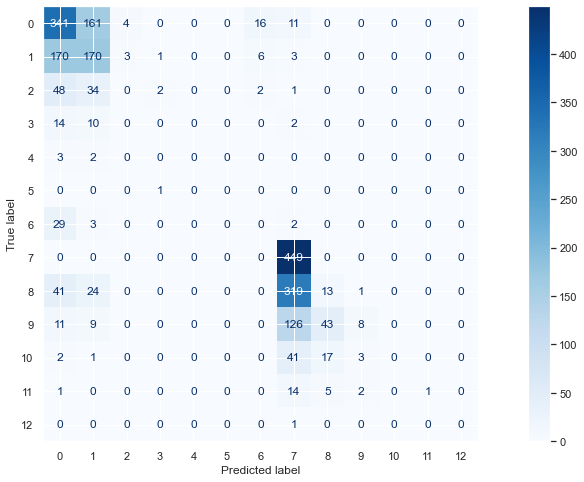

In [54]:
# set the plot size
plt.rcParams["figure.figsize"] = (18,8)

# Split the data once and plot confusion matrix
train_index, test_index in list(skf.split(X, y))[0]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
top_forest.fit(X_train, y_train)

# plot the confusion matrix
plot_confusion_matrix(top_forest, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

While performance was low, this analysis was quite informative. Next semester, take a look at additional datasets and ask questions to why performance was low this time around. We should focus on strictly tornados first and find ways to preserve as much of the sample size as possible. We lost many observations due to lack of weather data and lack of coordinates assigned to each storm event. 

## Appendix
Various plots, queries, and questions asked along the way

In [56]:
# Plot the change in performance with each parameter configuration